<h1> Shot-Scale Detector Using <code>fastai</code> That Can Be Ported To CoreML via ONNX

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# multiple cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
from fastai.vision import *
from fastai.metrics import accuracy, Precision, Recall
from fastai.callbacks import *

## Setup

In [3]:
path = Path('/home/rahul/github_projects/CinemaNet/')

### Data Augmentations
<br>

In addition to `fastai`'s `get_transforms()`, we apply some additional data augmentation with custom probabilities. <br>
There is no particular logic applied while picking these.

In [4]:
to_film_ar = lambda height: (height, int(height * 16/9))

In [5]:
def xtra_tfms(base_size): 
    box_dim = int(base_size/4)
    cutout_ = partial(cutout, p = .3, n_holes = (1,1), length = (box_dim, box_dim))
    jitter_ = partial(jitter, p = .3,  magnitude = (0.005, 0.01))
    skew_   = partial(skew,   p=.3, direction = (0, 7), magnitude = 0.2)
    squish_ = partial(squish, p=.3, row_pct = 0.25, col_pct = 0.25)
    tilt_   = partial(tilt,   p=.3, direction = (0, 3))
    perp_warp_ = partial(perspective_warp, p=.3, magnitude = (-0.2, 0.2))
    crop_pad_  = partial(crop_pad, p=.3, padding_mode = 'border', row_pct = 0.1, col_pct = 0.1)
    rgb_randomize_ = partial(rgb_randomize, thresh=0.05)
    #dihedral_  = partial(dihedral, ())
    
    xtra_tfms = [jitter_(), skew_(), squish_(), perp_warp_(),
                 tilt_(), cutout_(), crop_pad_()]
    
    return xtra_tfms

In [6]:
def get_tfms(base_size): return get_transforms(do_flip = True,
                                               flip_vert = False,
                                               max_zoom = 1.,
                                               max_lighting = 0.4,
                                               max_warp = 0.3,
                                               p_affine = 0.85,
                                               p_lighting = 0.85,
                                               xtra_tfms = xtra_tfms(base_size))

### Create Dataset

In [7]:
def get_data(path, base_size, batch_size, num_workers=None):
    return ImageDataBunch.from_folder(path, 'train', 'valid', 
                                      size    = to_film_ar(base_size),
                                      ds_tfms = get_tfms(base_size), bs=batch_size,
                                      resize_method = ResizeMethod.SQUISH,
                                      num_workers = num_workers,
                                     ).normalize(imagenet_stats)

### Setup Custom Head
<br>

`Fastai` 's custom `Flatten` layer contains an operator that is not supported by ONNX, so we need to replace that function, and every other function that depends on it. <br>
The code modified is from [`fastai.vision.learner`](https://github.com/fastai/fastai/blob/master/fastai/vision/learner.py)

While these aren't being used right now with `MobileNetV2`, they will come in handy once we figure out how to make external models fully compatible with `fastai`

In [8]:
from fastai.vision.learner import cnn_config

In [9]:
def create_head(nf:int, nc:int, lin_ftrs:Optional[Collection[int]]=None, ps:Floats=0.5,
                concat_pool:bool=True, bn_final:bool=False):
    "Model head that takes `nf` features, runs through `lin_ftrs`, and about `nc` classes."
    lin_ftrs = [nf, 512, nc] if lin_ftrs is None else [nf] + lin_ftrs + [nc]
    ps = listify(ps)
    if len(ps) == 1: ps = [ps[0]/2] * (len(lin_ftrs)-2) + ps
    actns = [nn.ReLU(inplace=True)] * (len(lin_ftrs)-2) + [None]
    pool = AdaptiveConcatPool2d() if concat_pool else nn.AdaptiveAvgPool2d(1)
    #layers = [pool, Flatten()] ## ------- replacement happens here ------- ##
    layers = [pool, nn.Flatten()]
    for ni,no,p,actn in zip(lin_ftrs[:-1], lin_ftrs[1:], ps, actns):
        layers += bn_drop_lin(ni, no, True, p, actn)
    if bn_final: layers.append(nn.BatchNorm1d(lin_ftrs[-1], momentum=0.01))
    return nn.Sequential(*layers)

def create_cnn_model(base_arch:Callable, nc:int, cut:Union[int,Callable]=None, pretrained:bool=True,
                     lin_ftrs:Optional[Collection[int]]=None, ps:Floats=0.5, custom_head:Optional[nn.Module]=None,
                     bn_final:bool=False, concat_pool:bool=True):
    "Create custom convnet architecture"
    body = create_body(base_arch, pretrained, cut)
    if custom_head is None:
        nf = num_features_model(nn.Sequential(*body.children())) * (2 if concat_pool else 1)
        head = create_head(nf, nc, lin_ftrs, ps=ps, concat_pool=concat_pool, bn_final=bn_final)
    else: head = custom_head
    return nn.Sequential(body, head)

def cnn_learner(data:DataBunch, base_arch:Callable, cut:Union[int,Callable]=None, pretrained:bool=True,
                lin_ftrs:Optional[Collection[int]]=None, ps:Floats=0.5, custom_head:Optional[nn.Module]=None,
                split_on:Optional[SplitFuncOrIdxList]=None, bn_final:bool=False, init=nn.init.kaiming_normal_,
                concat_pool:bool=True, **kwargs:Any)->Learner:
    "Build convnet style learner."
    meta = cnn_config(base_arch)
    model = create_cnn_model(base_arch, data.c, cut, pretrained, lin_ftrs, ps=ps, custom_head=custom_head,
        bn_final=bn_final, concat_pool=concat_pool)
    learn = Learner(data, model, **kwargs)
    learn.split(split_on or meta['split'])
    if pretrained: learn.freeze()
    if init: apply_init(model[1], init)
    return learn

### Callbacks, Metrics

In [10]:
metrics   = [accuracy, Precision(), Recall()]

def get_callbacks(learner, mod_name, early_stop=False, patience=8, monitor='accuracy', min_delta=0.01):
    callbacks=[
        SaveModelCallback(learner, every='improvement', name=f'{mod_name}-opt_accuracy', monitor='accuracy'),
        SaveModelCallback(learner, every='improvement', name=f'{mod_name}-opt_val_loss')
    ]
    if early_stop: callbacks.append(EarlyStoppingCallback(learner, patience=patience, min_delta=min_delta, monitor=monitor))
    return callbacks

## Training: Stage 1 -- `MobileNetV2`

<center>Image Size ⟶ 64 x 113 </center>

### Setup Data + Model

['Close-Up',
 'Extreme Close-Up',
 'Extreme Wide',
 'Long',
 'Medium',
 'Medium Close-Up']

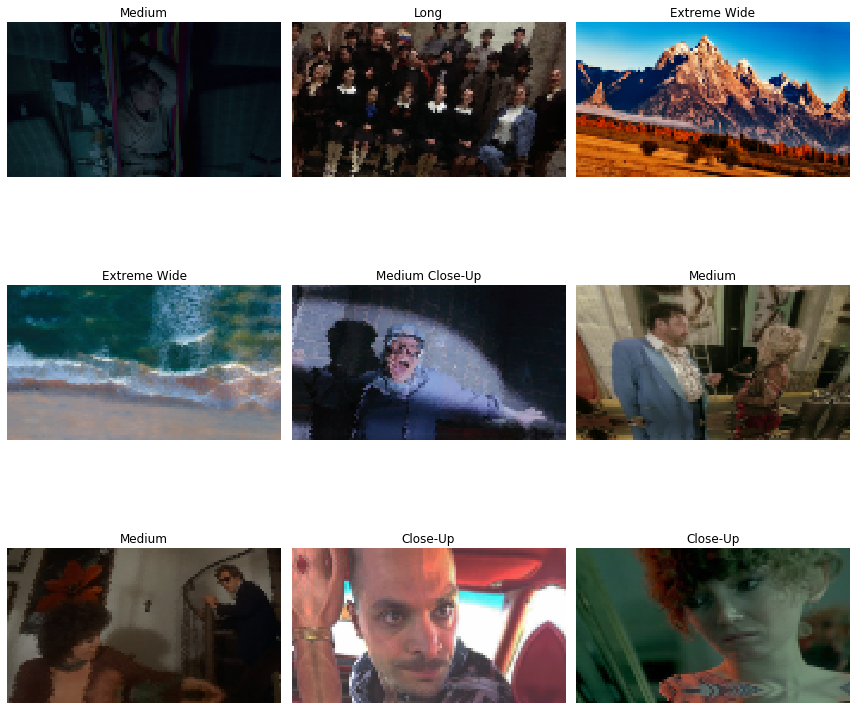

In [12]:
data = get_data(path, base_size=65, batch_size=256, num_workers=20)
data.show_batch(rows=3)
data.classes

In [13]:
import torchvision.models as tmodels

In [22]:
model = tmodels.mobilenet_v2(pretrained=True)
model.classifier.out_features=data.c
learn = Learner(data, model, metrics=metrics)
#learn = create_cnn(data, tmodels.MobileNetV2, metrics=metrics, pretrained=True)
learn = learn.to_fp16()

### Training the Frozen Model (Model Head)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


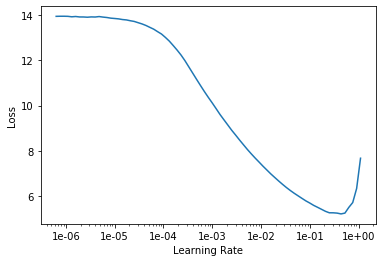

In [15]:
learn.lr_find()
learn.recorder.plot()

**Picking A Good Learning Rate** <br>
As mentioned in the `fastai` lectures, you want to pick a learning rate at a point in the graph where the slope is steep, and not at its lowest point. <br>
For further reading on the approach used here to pick good learning rates, see [Sylvain Gugger's Blog Post](https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html#how-do-you-find-a-good-learning-rate), [Leslie N. Smith's Paper](https://arxiv.org/abs/1506.01186)

In [38]:
model_name = 'MobileNetV2-stage1-im_base_64-frozen'
callbacks  = get_callbacks(learn, model_name)

In [39]:
learn.fit_one_cycle(10, 1e-3, callbacks=callbacks)

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,8.518866,3.930799,0.590000,nan,nan,00:45
1,4.238324,1.128411,0.750000,nan,nan,00:45
2,2.569104,0.747277,0.755000,nan,nan,00:45
3,1.752270,0.577213,0.823333,nan,nan,00:43
4,1.279552,0.540287,0.826667,nan,nan,00:42
5,0.989417,0.516006,0.821667,nan,nan,00:52
6,0.793630,0.471485,0.841667,nan,nan,00:50
7,0.652782,0.472734,0.845000,nan,nan,00:47
8,0.554043,0.496082,0.836667,nan,nan,00:47
9,0.489222,0.481466,0.841667,nan,nan,00:47


Better model found at epoch 0 with accuracy value: 0.5899999737739563.
Better model found at epoch 0 with valid_loss value: 3.9307987689971924.


/home/rahul/fastai/fastai/metrics.py:191: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


Better model found at epoch 1 with accuracy value: 0.75.
Better model found at epoch 1 with valid_loss value: 1.1284114122390747.
Better model found at epoch 2 with accuracy value: 0.7549999952316284.
Better model found at epoch 2 with valid_loss value: 0.7472772598266602.
Better model found at epoch 3 with accuracy value: 0.8233333230018616.
Better model found at epoch 3 with valid_loss value: 0.5772127509117126.
Better model found at epoch 4 with accuracy value: 0.8266666531562805.
Better model found at epoch 4 with valid_loss value: 0.5402865409851074.
Better model found at epoch 5 with valid_loss value: 0.5160062313079834.
Better model found at epoch 6 with accuracy value: 0.8416666388511658.
Better model found at epoch 6 with valid_loss value: 0.47148504853248596.
Better model found at epoch 7 with accuracy value: 0.8450000286102295.


In [49]:
learn.load(f'{model_name}-opt_accuracy');

TODO: Troubleshoot why `Precision` and `Recall` are `nan`s

### Interpret

In [50]:
learn.load(f'{model_name}-opt_accuracy');

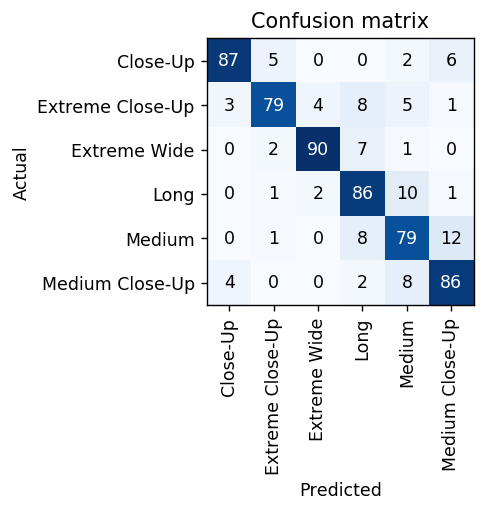

In [52]:
interpret = ClassificationInterpretation.from_learner(learn)
interpret.plot_confusion_matrix(dpi=125)

In [56]:
interpret.most_confused()

[('Medium', 'Medium Close-Up', 12),
 ('Long', 'Medium', 10),
 ('Extreme Close-Up', 'Long', 8),
 ('Medium', 'Long', 8),
 ('Medium Close-Up', 'Medium', 8),
 ('Extreme Wide', 'Long', 7),
 ('Close-Up', 'Medium Close-Up', 6),
 ('Close-Up', 'Extreme Close-Up', 5),
 ('Extreme Close-Up', 'Medium', 5),
 ('Extreme Close-Up', 'Extreme Wide', 4),
 ('Medium Close-Up', 'Close-Up', 4),
 ('Extreme Close-Up', 'Close-Up', 3),
 ('Close-Up', 'Medium', 2),
 ('Extreme Wide', 'Extreme Close-Up', 2),
 ('Long', 'Extreme Wide', 2),
 ('Medium Close-Up', 'Long', 2),
 ('Extreme Close-Up', 'Medium Close-Up', 1),
 ('Extreme Wide', 'Medium', 1),
 ('Long', 'Extreme Close-Up', 1),
 ('Long', 'Medium Close-Up', 1),
 ('Medium', 'Extreme Close-Up', 1)]

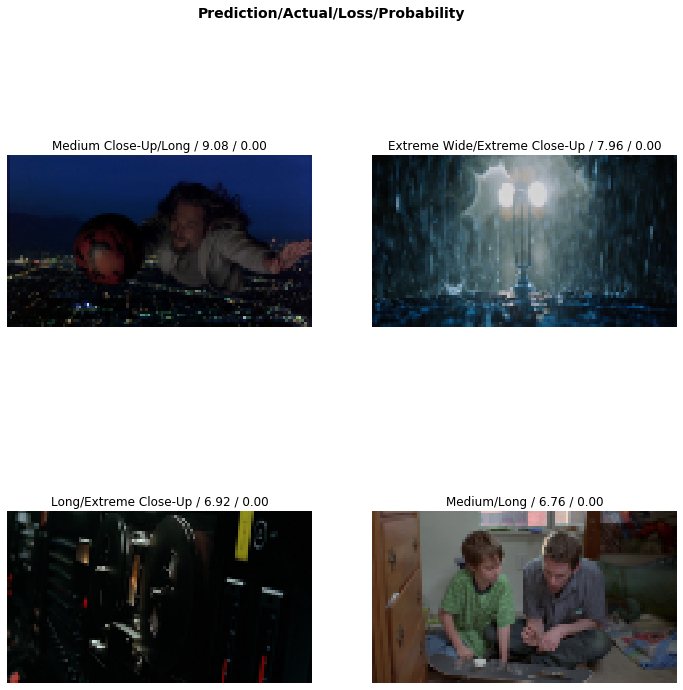

In [62]:
interpret.plot_top_losses(4)

Every one of the above except the bottom-left are understandable. In the future, do some tweaking to display more of these images without their titles clashing (as they would if you plotted more than 4)

### Unfreezing and Fine Tuning

In [73]:
learn.load(f'{model_name}-opt_accuracy');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


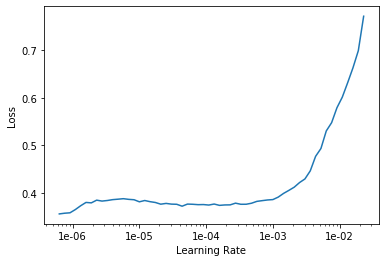

In [64]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [74]:
model_name = 'MobileNetV2-stage1-im_base_64-unfrozen'
callbacks  = get_callbacks(learn, model_name, patience=3)

In [75]:
learn.fit_one_cycle(3, 1e-3, callbacks=callbacks)

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,0.468938,0.666063,0.808333,nan,nan,00:43
1,0.532881,0.655909,0.785000,nan,nan,00:50
2,0.500217,0.524671,0.815000,nan,nan,00:50


Better model found at epoch 0 with accuracy value: 0.8083333373069763.
Better model found at epoch 0 with valid_loss value: 0.6660631895065308.
Better model found at epoch 1 with valid_loss value: 0.6559085845947266.
Better model found at epoch 2 with accuracy value: 0.8149999976158142.
Better model found at epoch 2 with valid_loss value: 0.5246707797050476.


In [76]:
learn.load(f'{model_name}-opt_accuracy');

In [77]:
learn.fit_one_cycle(3, 1e-4, callbacks=callbacks)

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,0.402643,0.500270,0.823333,nan,nan,00:47
1,0.374147,0.507910,0.820000,nan,nan,00:50
2,0.356442,0.518258,0.818333,nan,nan,00:50


Better model found at epoch 0 with accuracy value: 0.8233333230018616.
Better model found at epoch 0 with valid_loss value: 0.5002702474594116.


It's really difficult to fine-tune an unfrozen model effectively without discriminative learning rates (`slice(1e-6, 1e-3)`). <br>
We can't use all of fastai's functionality because using an external model doesn't create layer groups automatically; the entire model is read in as one layer group. (discriminative learning rates apply progressively increasing learning rates to the layer groups -- the first few layers get the lowest LR whereas the later ones get the highest)

In [90]:
%%capture

learn.load('MobileNetV2-stage1-im_base_64-frozen-opt_accuracy')
mobilenet=learn

## Training: Stage 1 -- `SqueezeNet1_1`

<center>Image Size ⟶ 64 x 113 </center>

### Setup Data + Model

In [84]:
data = get_data(path, base_size=64, batch_size=256, num_workers=22)

In [100]:
learn = cnn_learner(data, models.squeezenet1_1, pretrained=True, metrics=metrics)

epoch,train_loss,valid_loss,time
0,2.968313,#na#,00:36
1,2.881063,#na#,00:38
2,2.365974,#na#,00:36
3,2.219014,#na#,00:35


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


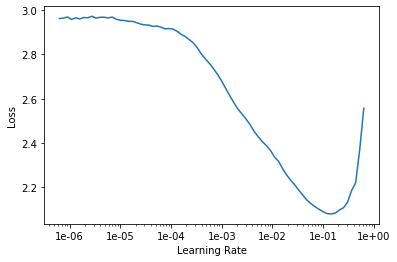

In [93]:
learn.lr_find()
learn.recorder.plot()

In [98]:
model_name = 'SqueezeNet1_1-im_base_64-frozen'
callbacks = get_callbacks(learn, model_name, patience=3)

In [101]:
learn.fit_one_cycle(7, 1e-3, callbacks=callbacks)

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,2.499386,1.318481,0.503333,0.511242,0.503333,00:46
1,1.987393,1.079209,0.625000,0.646170,0.625000,00:46
2,1.694865,1.023194,0.631667,0.667177,0.631667,00:43
3,1.492267,0.999613,0.636667,0.674286,0.636667,00:43
4,1.363101,0.964898,0.648333,0.678568,0.648333,00:46
5,1.267561,0.963233,0.643333,0.678056,0.643333,00:45
6,1.208884,0.965858,0.643333,0.679310,0.643333,00:46


Better model found at epoch 0 with accuracy value: 0.6566666960716248.
Better model found at epoch 0 with valid_loss value: 0.8923584222793579.


Traceback (most recent call last):
  File "/home/rahul/anaconda3/lib/python3.7/multiprocessing/queues.py", line 232, in _feed
    close()
  File "/home/rahul/anaconda3/lib/python3.7/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/home/rahul/anaconda3/lib/python3.7/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
Traceback (most recent call last):
  File "/home/rahul/anaconda3/lib/python3.7/multiprocessing/queues.py", line 232, in _feed
    close()
  File "/home/rahul/anaconda3/lib/python3.7/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/home/rahul/anaconda3/lib/python3.7/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
Traceback (most recent call last):
  File "/home/rahul/anaconda3/lib/python3.7/multiprocessing/queues.py", line 232, in _feed
    close()
  File "/home/rahul/anaconda3/lib/python

In [102]:
learn.load(f'{model_name}-opt_accuracy');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


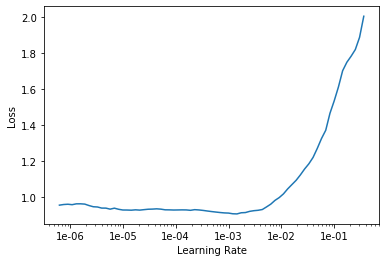

In [103]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [104]:
model_name = 'SqueezeNet1_1-im_base_64-unfrozen'
callbacks = get_callbacks(learn, model_name, patience=3)

In [105]:
learn.fit_one_cycle(10, slice(1e-6, 1e-3), callbacks=callbacks)

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,0.925618,0.878910,0.673333,0.704133,0.673333,00:45
1,0.890367,0.882694,0.656667,0.701650,0.656667,00:45
2,0.867933,0.810979,0.706667,0.736885,0.706667,00:49
3,0.830094,0.798560,0.710000,0.730873,0.710000,00:49
4,0.794562,0.754323,0.725000,0.751580,0.725000,00:46
5,0.767233,0.746553,0.731667,0.752956,0.731667,00:47
6,0.748883,0.761746,0.713333,0.739541,0.713333,00:47
7,0.726959,0.724783,0.735000,0.754128,0.735000,00:44
8,0.712254,0.730085,0.725000,0.747412,0.725000,00:46
9,0.701143,0.729683,0.726667,0.748156,0.726667,00:47


Better model found at epoch 0 with accuracy value: 0.6733333468437195.
Better model found at epoch 0 with valid_loss value: 0.8789103031158447.
Better model found at epoch 2 with accuracy value: 0.7066666483879089.
Better model found at epoch 2 with valid_loss value: 0.8109794855117798.
Better model found at epoch 3 with accuracy value: 0.7099999785423279.
Better model found at epoch 3 with valid_loss value: 0.7985595464706421.
Better model found at epoch 4 with accuracy value: 0.7250000238418579.
Better model found at epoch 4 with valid_loss value: 0.7543232440948486.
Better model found at epoch 5 with accuracy value: 0.7316666841506958.
Better model found at epoch 5 with valid_loss value: 0.7465530633926392.
Better model found at epoch 7 with accuracy value: 0.7350000143051147.
Better model found at epoch 7 with valid_loss value: 0.7247831225395203.


## Export to CoreML
[This](https://github.com/davidpfahler/react-native-ml-app/blob/e4abc813f2c3e7e147454afbcbb4edd14c9ffe16/train_dog_classifier_with_fastai_export_to_CoreML.ipynb) notebook is the source that all the `ONNX` and `CoreML` relevant material is borrowed from. 

### Fastai ⟶ ONNX

In [20]:
to_film_ar(150)

(150, 266)

In [21]:
%%capture

learn.model.eval()
save_path = '../models/shot-scale-classifier.onnx'
x = torch.randn(1, 3, 150, 266, requires_grad=False).cuda()

In [22]:
torch_out = torch.onnx._export(learn.model, x, save_path, export_params=True)

### ONNX ⟶ CoreML

In [3]:
red_scale = 1.0 / (0.229 * 255.0)
green_scale = 1.0 / (0.224 * 255.0)
blue_scale = 1.0 / (0.225 * 255.0)

args = dict(is_bgr=False, red_bias = -(0.485 * 255.0)  , green_bias = -(0.456 * 255.0)  , blue_bias = -(0.406 * 255.0))

In [4]:
import copy
import coremltools
import os

from onnx_coreml import convert
from onnx import onnx_pb

In [5]:
convert_model = convert(
    model='../models/shot-scale-classifier.onnx', mode='classifier', image_input_names=['input.1'], 
    #class_labels=[i for i in range(data.c)], preprocessing_args=args,
    class_labels=[i for i in range(6)], preprocessing_args=args,
    target_ios='13'
)

1/185: Converting Node Type Conv
2/185: Converting Node Type BatchNormalization
3/185: Converting Node Type Relu
4/185: Converting Node Type MaxPool
5/185: Converting Node Type Conv
6/185: Converting Node Type BatchNormalization
7/185: Converting Node Type Relu
8/185: Converting Node Type Conv
9/185: Converting Node Type BatchNormalization
10/185: Converting Node Type Relu
11/185: Converting Node Type Conv
12/185: Converting Node Type BatchNormalization
13/185: Converting Node Type Conv
14/185: Converting Node Type BatchNormalization
15/185: Converting Node Type Add
16/185: Converting Node Type Relu
17/185: Converting Node Type Conv
18/185: Converting Node Type BatchNormalization
19/185: Converting Node Type Relu
20/185: Converting Node Type Conv
21/185: Converting Node Type BatchNormalization
22/185: Converting Node Type Relu
23/185: Converting Node Type Conv
24/185: Converting Node Type BatchNormalization
25/185: Converting Node Type Add
26/185: Converting Node Type Relu
27/185: Conv

In [8]:
spec = convert_model.get_spec()
nn_spec = spec.

SyntaxError: invalid syntax (<ipython-input-8-4390b959a23b>, line 2)

In [9]:
spec = convert_model.get_spec()
nn_spec = spec.neuralNetworkClassifier
layers = nn_spec.layers # this is a list of all the layers
layers_copy = copy.deepcopy(layers) # make a copy of the layers, these will be added back later
del nn_spec.layers[:] # delete all the layers

In [10]:
# add a scale layer now
# since mlmodel is in protobuf format, we can add proto messages directly
# To look at more examples on how to add other layers: see "builder.py" file in coremltools repo
scale_layer = nn_spec.layers.add()
scale_layer.name = 'scale_layer'
scale_layer.input.append('input.1')
scale_layer.output.append('input1_scaled')
params = scale_layer.scale
params.scale.floatValue.extend([red_scale, green_scale, blue_scale]) # scale values for RGB
params.shapeScale.extend([3,1,1]) # shape of the scale vector 

# now add back the rest of the layers (which happens to be just one in this case: the crop layer)
nn_spec.layers.extend(layers_copy)

# need to also change the input of the crop layer to match the output of the scale layer
nn_spec.layers[1].input[0] = 'input1_scaled'

In [13]:
coreml_model = coremltools.models.MLModel(spec)
coreml_model.save('../models/shot-scale-classifier.mlmodel')